In [3]:
#@title Load Required Packages & Libraries
import imutils,random, cv2, os, pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from copy import deepcopy
import pandas as pd

# plt.style.use('dark_background')

In [4]:
#@title Display Image
def display_image(input_img, display_title=None, plt_width_height=None):
    if not plt_width_height is None:
        plt.rcParams['figure.figsize'] = plt_width_height
    im_shape = input_img.shape
    c = 3
    if len(im_shape) >= 3:
        c = im_shape[2]
    if len(im_shape) == 2:
        c = 1

    if c == 3:
        rgb_img = cv2.cvtColor(input_img.copy(), cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_img)

    if c == 1:
        plt.imshow(input_img,cmap='gray')

    plt.axis('off')
    plt.grid(False)
    if not display_title is None:
        plt.title(display_title)
    plt.show()

Defining Custom Utility Functions

In [5]:
#@title Draw Points on image
def draw_points(img, co_ors, colors):
    '''
    Function draws points with on the coordinates with respective color
    Parameters : 
    img : Image matrix
    co_ors :  List of co-ordinates to draw points
    colors  : List of colors to draw the eachp point in co_ors
    Returns :
    img_draw  : Image matrix with points drawn
    '''
    for c, color in zip(co_ors, colors):
        img_draw = cv2.circle(img, tuple(c), radius=0, color=color, thickness=15)
    return img_draw

In [8]:
#@title Rotate the image at an angle
def rotate_image(img, degrees):
    '''
    Function rotates the image at the specified angle (degrees)
    Parameters : 
    img : Image matrix
    degrees :  Angle of rotation in degrees
    Returns :
    rotated_image : Rotated image matrix
    '''  
    h, w = img.shape[:2]
    center = (w/2, h/2)
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=degrees, scale=1)
    rotated_image = cv2.warpAffine(src=img, M=rotate_matrix, dsize=(w, h))
    return rotated_image

In [9]:
#@title Get the rotated coordinates
def get_rotated_coordinates(co_ors, degrees, h, w):
    '''
    Function calculates new coordinates after rotation
    Parameters : 
    co_ors : Original co-corinates
    degrees :  Angle of rotation in degrees
    h : Height of image matrix
    w : Width of image matrix
    Returns :
    rot_co_ors : New co-ordinates after rotation
    '''  
    rot_co_ors = []
    rad = np.deg2rad(degrees)
    for i in co_ors:
        x, y = i
        y = y - h/2
        x = x - w/2
        y1 = int(y*np.cos(rad) - x*np.sin(rad) + h/2)
        x1 = int(x*np.cos(rad) + y*np.sin(rad) + w/2)
        rot_co_ors.append([x1, y1])
    return rot_co_ors

In [10]:
#@title Getting lines that are along the L shape
def get_right_lines(lines):
    '''
    Function selects the lines along the L shape of datamatrix
    Parameters : 
    lines : List of lines
    Returns :
    new_lines : Selected lines along L shape
    '''
    angles = []
    new_lines = []
    if len(lines) == 2:
        new_lines = lines.copy()
        return new_lines
    for i in lines:
        angles.append(np.degrees(np.arctan2(i[2] - i[0], i[3] - i[1])))
    if abs(angles[0]-angles[1]) > 80 and abs(angles[0]-angles[1]) < 100:
        new_lines = [lines[0], lines[1]]
    else:
        new_lines = [lines[0], lines[2]]
    return new_lines

In [11]:
#@title Fining intersection point of the 2 lines
def findIntersection(x1,y1,x2,y2,x3,y3,x4,y4):
    '''
    Function finds the point of intersection of 2 lines
    Parameters : 
    x1  : x1 Coordinate
    y1  : y1 Coordinate
    x2  : x2 Coordinate
    y2  : y2 Coordinate
    x3  : x3 Coordinate
    y3  : y3 Coordinate
    x4  : x4 Coordinate
    y4  : y4 Coordinate
    Returns :
    [px, py] : X and Y co-ordinates of intersection point
    '''
    px= int(( (x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) )) 
    py= int(( (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4) ) / ( (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4) ))
    return [px, py]

In [12]:
#@title Deriving actual line equation(points) from hough lines
def draw_lines(houghLines):
    '''
    Function selects best lines out of detected lines
    Parameters : 
    houghLines :  Detected Hough Lines 
    Returns :
    lines : List of best selected lines (2-3) 
    '''
    lines = []
    i = 0
    for line in houghLines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            lines.append([x1,y1,x2,y2])
        i+=1
        if i == 3:
            break
    return lines

**Iterating through folder and running the algorithm on every image**

**Steps :**


1.   Read the image
2.   Get co-ordinates
3.   Get minimum area rectangle and get the *angle* of rotated rectangle
4.   Crop a small patch that contains the datamatrix along with some extra region
5.   Get edges using **Canny edge detection**
6.   Get **Hough Lines** and select best ones and ones that pass aloong L shape
7.   Get point of intersection of lines (Common corner)
8.   Rotate the patch in such a way that *common corner* falls at bottom left position (using angle obtained at minimum area rectangle), to get the angle of rotation for each image
9.   Rotate the original image
10.  Draw points in specified colors
11.  Crop the image to get desired patch




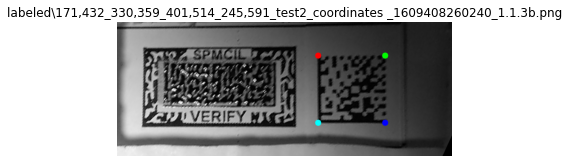

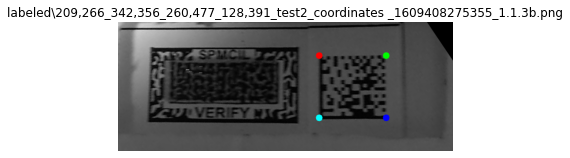

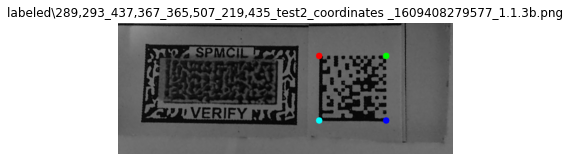

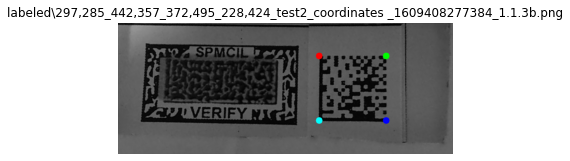

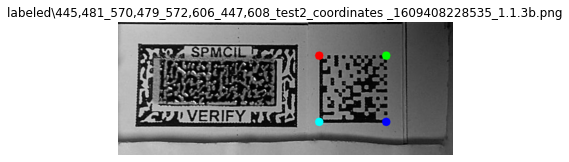

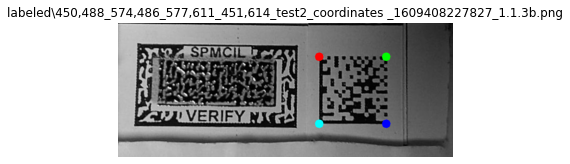

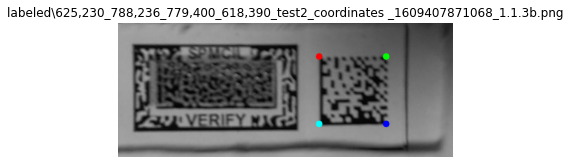

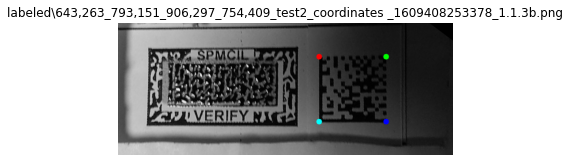

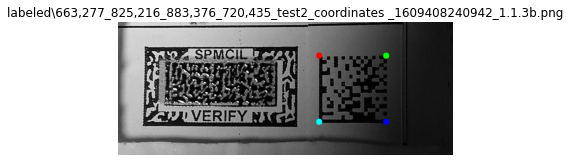

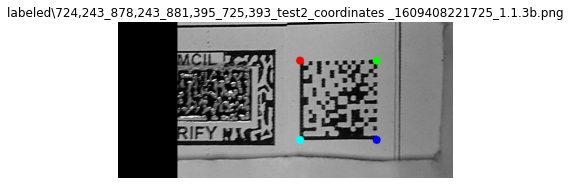

In [13]:
# Iterating through all the images in data_matrix_iamge_with_corner folder
for imgs in os.listdir('labeled'):
    path = os.path.join('labeled', imgs)
    img = cv2.imread(path)
    img_orig = img.copy()
    # Getting the coordinates of the matrix
    co_ors = []
    for items in os.path.basename(path).split('_')[0:4]:
        temp = [int(j) for j in items.split(',')]
        co_ors.append([temp])
    co_ors = np.array(co_ors)
    # Getting the minimum area rectangle along datamatrix
    min_rect = cv2.minAreaRect(co_ors)
    # Getting angle of minimum area rectangle
    angle = min_rect[-1]
    min_rect = np.int0(cv2.boxPoints(min_rect))
    # Cropping the patch containing datamatrix to run edge detection
    # to detect the L shape of datamatrix
    x_ = [i[0] for i in min_rect]
    y_ = [i[1] for i in min_rect]
    x_.sort()
    y_.sort()
    # Cropping a slightly bigger area so that edge detection works properly
    for i in range(len(min_rect)):
        if min_rect[i][0] in x_[:2]:
            min_rect[i][0]-=15
        else:
            min_rect[i][0]+=15
        if min_rect[i][1] in y_[:2]:
            min_rect[i][1]-=15
        else:
            min_rect[i][1]+=15
    # Getting the extreme co-ordinates to crop the patch
    xmin = min([i[0] for i in min_rect])
    xmax = max([i[0] for i in min_rect])
    ymin = min([i[1] for i in min_rect])
    ymax = max([i[1] for i in min_rect])
    # Cropping datamatrix with some padding
    img = img[ymin:ymax, xmin:xmax]
    img1 = img.copy()
    # Preprocessing before Canny Edge Detection
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(img, (9, 9), 0)
    # Running Canny edge detection
    edges_image = cv2.Canny(blurred_image, 50, 120)
    # Getting Hough Lines out of the Output edges
    # Defining some parameters for Hough Lines algorithm
    rho_resolution = 2
    theta_resolution = np.pi/180
    threshold = 120
    hough_lines = cv2.HoughLines(edges_image, rho_resolution , theta_resolution , threshold)
    # Getting best lines out of all detected lines
    lines = draw_lines(hough_lines)
    # Getting lines that fall along L shape (almost perpendicular to each other)
    lines = get_right_lines(lines)
    # Getting the point if intersection of the lines (the Common corner : Cyan)
    try:
        pts = findIntersection(lines[0][0],lines[0][1],lines[0][2],lines[0][3],lines[1][0],lines[1][1],lines[1][2],lines[1][3])
    except:
        print('Divide by Zero Error, Skipping Image')
        continue
    # Rotating the matrix by 4 different angles and selecting the angle for which
    # common corner falls in the extreme left, extreme bottom position
    # Could have been done using xmin, ymax, but due to slight variation
    # in the coordinate values (around 1 pixels), it could not be done
  
    # Rotating by angle derived in minAreaRect and with multiples of 90
    # added to it 
    p1 = get_rotated_coordinates([pts], angle, img.shape[0], img.shape[1])
    p2 = get_rotated_coordinates([pts], angle+90, img.shape[0], img.shape[1])
    p3 = get_rotated_coordinates([pts], angle+180, img.shape[0], img.shape[1])
    p4 = get_rotated_coordinates([pts], angle+270, img.shape[0], img.shape[1])
    pts = [p1[0],p2[0],p3[0],p4[0]]
    pts1 = pts.copy()
    xmin = [i[0] for i in pts]
    xmin.sort()
    xmin = xmin[-2:]
    pts = [i for i in pts if i[0] in xmin]
    if pts[0][1]>pts[1][1]:
        value = pts[0]
    else:
        value = pts[1]
    index = pts1.index(value)
    # This is out final angle of rotation
    angle = angle + 90*(index-1)
    # Finally, rotating the original image around the calculated angle and
    # drawing points in specified colors
    new_co = []
    for items in os.path.basename(path).split('_')[0:4]:
        new_co.append([int(j) for j in items.split(',')])
    final_image = rotate_image(img_orig, angle)
    rotated_co = get_rotated_coordinates(new_co, angle, final_image.shape[0], final_image.shape[1])
    xmin = min([i[0] for i in rotated_co])
    xmax = max([i[0] for i in rotated_co])
    ymin = min([i[1] for i in rotated_co])
    ymax = max([i[1] for i in rotated_co])
    points = [[xmin, ymax], [xmin, ymin], [xmax, ymax], [xmax, ymin]]
    # (255,255,0) : Cyan for the common corner of L
    # (0,0,255) : Blue for corner horizontally at same level as the common corner
    # (255,0,0) : Red for the corner vertically above the common corner
    # (0, 255, 0) : Green for corner opposite to common corner
    draw_points(final_image, points, [(255,255,0), (0,0,255), (255,0,0), (0, 255, 0)])
    # Also, taking length of the side to crop the required patch 
    # out of original image. This value was ascertained manually.
    length = xmax-xmin
    # Cropping the final image
    final_image = final_image[max(ymin-int(length/2),0):min(ymax+int(length/2),final_image.shape[0]), max(xmin-length*3, 0):min(xmax+length, final_image.shape[1])]
    # Either save the image or display the image or both
    #cv2.imwrite(path[:-4]+'_out.png', final_image)    
    display_image(final_image, path)

**Bonus Section**

Performing required installations

In [ ]:
!pip3 install pylibdmtx

Had to install this due to an error
Please refer : https://github.com/dmtx/libdmtx/issues/31#issuecomment-578813522

In [ ]:
!sudo apt-get install libdmtx0a

In [14]:
from pylibdmtx.pylibdmtx import decode

**Steps**


1.   Reading the image
2.   Getting binary mask by running hsv segmentation
3.   Running canny edge detection
4.   Getting Hough Lines and selecting best lines and lines along L shape
5.   Finding point of intersection (Common corner)
6.   Using binary mask to decode the datamatrix
7.   Adjusting co-ordinates to align perfectly with the corners of datamatrix
8.   Draw points in specified colors
**Note** : In this solution, we didn't directly apply the decoded coordinates because they don't align perfectly with the corners of datamatrix. So, using a subset of the approach in the above algorithm, we get the intercepts to adjust the decoded co-ordinates and then draw the points

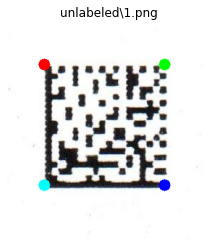

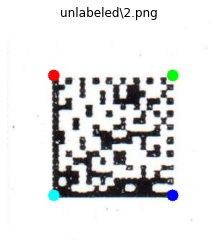

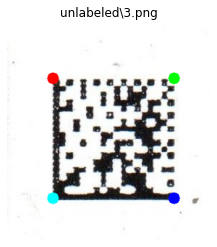

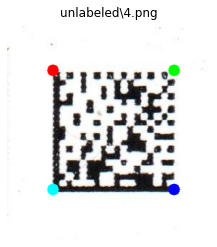

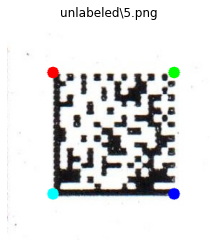

In [17]:
# In order to get best output, we threshold the datamatrix using hsv color segmentation
# Defining HSV lower and upper range
l_r = (0, 0, 0)
u_r = (179, 255, 150)  
# Iterating through images and running our algorithm on them
for imgs in os.listdir('unlabeled'):
    path = os.path.join('unlabeled', imgs)
    if '.png' not in path:
        continue
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_gray, l_r, u_r) 
  
    # When we directly use the co-ordinates of decoded datamatrix, they don't
    # align with the corners perfectly. So, to increase the robustness, we
    # again run canny edge detection and Hough Lines to get the actual 
    # position of the Common corner. Then, we calculate the x and y intercepts
    # to get the aligned co-ordinates of 4 points

    # Running Canny edge detection on masked value
    edges_image = cv2.Canny(mask, 50, 120)
    # Getting Hough Lines out of the Output edges
    # Defining some parameters for Hough Lines algorithm
    rho_resolution = 2
    theta_resolution = np.pi/180
    threshold = 120
    hough_lines = cv2.HoughLines(edges_image, rho_resolution , theta_resolution , threshold)
    # Getting best lines out of all detected lines
    lines = draw_lines(hough_lines)
    # Getting lines that fall along L shape (almost perpendicular to each other)
    lines = get_right_lines(lines)
    # Getting the point if intersection of the lines (the Common corner : Cyan)
    try:
        pts = findIntersection(lines[0][0],lines[0][1],lines[0][2],lines[0][3],lines[1][0],lines[1][1],lines[1][2],lines[1][3])
    except:
        print('Error')
        continue
    # Inverting the binary mask
    mask = np.bitwise_not(mask)
    # Decoding datamatrix
    result = decode(mask)
    left, top, width, height = [int(i) for i in result[0][1]]
    # Calculating x and y intercepts
    x_diff = pts[0]-left
    y_diff = pts[1]-(top+height)
    # Getting the actual co-ordinates
    left += x_diff
    top += y_diff
    # Getting final co-ordinates to draw the points in specified colors
    points = [[left, top+height], [left, top], [left+width, top], [left+width, top+height]]
    cyan = (255, 255, 0)
    red = (0, 0, 255)
    green = (0, 255, 0)
    blue = (255, 0, 0)
    final_image = draw_points(img, points, [cyan, red, green, blue])
    display_image(final_image, path)